In [192]:
%matplotlib inline
from pylab import imshow
import numpy as np
import cv2
import torch
import albumentations as albu
from iglovikov_helper_functions.utils.image_utils import load_rgb, pad, unpad
from iglovikov_helper_functions.dl.pytorch.utils import tensor_from_rgb_image
from cloths_segmentation.pre_trained_models import create_model

import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [180]:
model = create_model("Unet_2020-10-30")
model.eval();

In [181]:
#this is collab pipeline you provided, i made no changes to it
def get_mask(image_path):
    image = load_rgb(image_path)
    # imshow(image)
    transform = albu.Compose([albu.Normalize(p=1)], p=1)
    padded_image, pads = pad(image, factor=32, border=cv2.BORDER_CONSTANT)
    x = transform(image=padded_image)["image"]
    x = torch.unsqueeze(tensor_from_rgb_image(x), 0)
    with torch.no_grad():
        prediction = model(x)[0][0]
    mask = (prediction > 0).cpu().numpy().astype(np.uint8)
    mask = unpad(mask, pads)
    return mask

In [182]:
FOLDER_NON_MASKED = "mask\cloths"
files = [os.path.join(FOLDER_NON_MASKED, f) for f in os.listdir(FOLDER_NON_MASKED) if os.path.isfile(os.path.join(FOLDER_NON_MASKED, f))]
masks = [get_mask(file) for file in tqdm(files)]
filenames = [a.split('\\')[-1][:-4] + '_mask.png' for a in files]

100%|██████████| 10/10 [00:47<00:00,  4.74s/it]


In [184]:
FOLDER_MASKS = "mask/masks/"
for a in zip(masks, filenames):
    cv2.imwrite(os.path.join(FOLDER_MASKS, a[1]), a[0]*255)

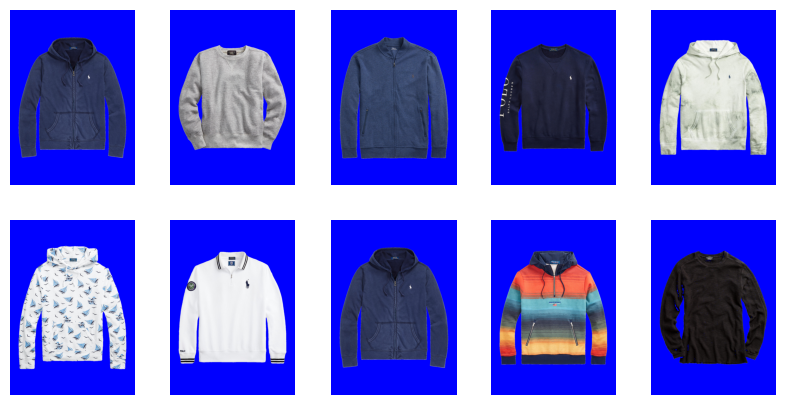

In [197]:
# version if we want to work with images directly
images_cloth = [cv2.imread(os.path.join(FOLDER_NON_MASKED, f), flags=cv2.IMREAD_COLOR) for f in os.listdir(FOLDER_NON_MASKED) if os.path.isfile(os.path.join(FOLDER_NON_MASKED, f))]
images_mask = [cv2.imread(os.path.join(FOLDER_MASKS, f), 0) for f in os.listdir(FOLDER_MASKS) if os.path.isfile(os.path.join(FOLDER_MASKS, f))]
def preprocess(cloth, cloth_mask):
    blue_background = np.zeros_like(cloth)
    blue_background[:] = (255, 0, 0)
    res = cv2.bitwise_and(cloth, cloth, mask = cloth_mask)
    res[np.all(res == [0, 0, 0], axis=-1)] = [255, 0, 0]
    return res
imgs = [preprocess(cloth, cloth_mask) for cloth, cloth_mask in zip(images_cloth, images_mask)]

# # version if we want to provide paths
# def preprocess(cloth, cloth_mask):
#     cloth = cv2.imread(cloth, flags=cv2.IMREAD_COLOR) 
#     cloth_mask = cv2.imread(cloth_mask, 0)
#     blue_background = np.zeros_like(cloth)
#     blue_background[:] = (255, 0, 0)
#     res = cv2.bitwise_and(cloth, cloth, mask = cloth_mask)
#     res[np.all(res == [0, 0, 0], axis=-1)] = [255, 0, 0]
#     return res
# imgs = [preprocess(os.path.join(FOLDER_NON_MASKED, a), os.path.join(FOLDER_MASKS, b)) for a,b in zip(os.listdir(FOLDER_NON_MASKED),os.listdir(FOLDER_MASKS))]

plt.figure(figsize=(10, 5))
for i, img in enumerate(imgs):    
    plt.subplot(2, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
plt.show()


In [198]:
FOLDER_PREPROCESSED = "mask/preprocessed/"
filenames_preprocessed = [a.replace('masked','preprocessed') for a in filenames]
for a in zip(imgs, filenames_preprocessed):
    cv2.imwrite(os.path.join(FOLDER_PREPROCESSED, a[1]), a[0])